## Installing necessary libraries

In [1]:
!sudo apt install tesseract-ocr

!pip install pytesseract
!pip install --upgrade pillow==6.2.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.4.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
  Attempting uninstall: Pillow
    Found existing installation: Pillow 6.2.2
    Uninstalling Pillow-6.2.2:
      Successfully uninstalled Pillow-6.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-6.2.2-cp38-cp38-manylinux1_x86_64.whl (2.1 MB)
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytesseract 0.3.10 requires Pillow>=8.0.0, but you have pillow 6.2.2 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 6.2.2 which is incompatible.


## Importing necessary packages

In [2]:
from google.colab import drive
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import cv2
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pytesseract
import time
import torch
import torchvision
import torchvision.transforms as transforms

## Defining constants

In [3]:
TRAIN_DATA_PATH = Path("/content/drive/MyDrive/FUNSD/training_data")
VALID_DATA_PATH = Path("/content/drive/MyDrive/FUNSD/validation_data")
TEST_DATA_PATH = Path("/content/drive/MyDrive/FUNSD/testing_data")

DEVICE = torch.device("cuda")

BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 3e-4
MOMENTUM = 0.9
NUM_CLASSES = 3
RESIZE_TO = 416
WEIGHT_DECAY = 0.0

BEST_MODEL_PATH = "/content/drive/MyDrive/FUNSD/models/best_model.pth"

## Preparing the dataset

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
def read_box_coordinates(label_path):
    boxes = []
    labels = []
    
    with open(label_path, 'r') as label_file:
      annotations = json.load(label_file)

      for annotation in annotations["form"]:
        boxes.append(annotation["box"])

        if annotation["label"] == "question":
          labels.append(1)
        else:
          labels.append(2)
            
    return boxes, labels

In [6]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [7]:
class InvoiceDataset(Dataset):
  def __init__(self, data_path, width, height, transforms=None):
    self.data_path = data_path
    self.width = width
    self.height = height
    self.transforms = transforms

    self.image_names = sorted(os.listdir(self.data_path / "images"))
    self.label_names = sorted(os.listdir(self.data_path / "annotations"))

  def __getitem__(self, idx):
    image_name = self.image_names[idx]
    image_path = self.data_path / "images" / image_name

    # Reading the image in grayscale format
    image = cv2.imread(str(image_path), 0).astype(np.float32)

    # Resizing the image
    image_resized = cv2.resize(image, (self.width, self.height))
    image_resized /= 255.0

    label_name = self.label_names[idx]
    label_path = self.data_path / "annotations" / label_name

    boxes, labels = read_box_coordinates(label_path)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)

    image_width = image.shape[1]
    image_height = image.shape[0]

    # Resizing bounding boxes
    boxes[:, 0] = boxes[:, 0] / image_width * self.width
    boxes[:, 1] = boxes[:, 1] / image_height * self.height
    boxes[:, 2] = boxes[:, 2] / image_width * self.width
    boxes[:, 3] = boxes[:, 3] / image_height * self.height

    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      image_resized = self.transforms(image_resized)

    return image_resized, target

  def __len__(self):
    return len(self.image_names)

In [8]:
train_dataset = InvoiceDataset(TRAIN_DATA_PATH, RESIZE_TO, RESIZE_TO, transforms.ToTensor())
valid_dataset = InvoiceDataset(VALID_DATA_PATH, RESIZE_TO, RESIZE_TO, transforms.ToTensor())

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

In [9]:
def visualize_sample(image, target):
  fig, ax = plt.subplots(figsize=(20, 10))
  temp_image = image.numpy()
  temp_image = np.moveaxis(temp_image, 0, -1).squeeze()
  ax.imshow(temp_image, cmap="gray")

  for box_num in range(len(target["boxes"])):
    box = target["boxes"][box_num]
    x = box[0]
    y = box[1]
    width = box[2] - box[0]
    height = box[3] - box[1]

    label = target["labels"][box_num]
    color = 'r' if label == 1 else 'b'

    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor="None")
    ax.add_patch(rect)
    
  plt.show()

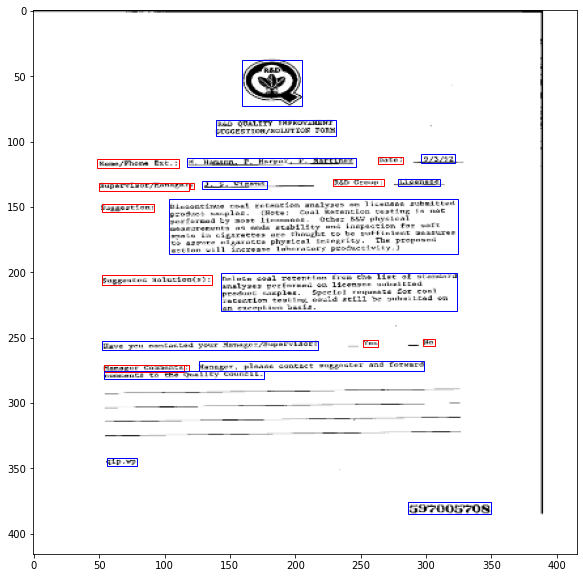

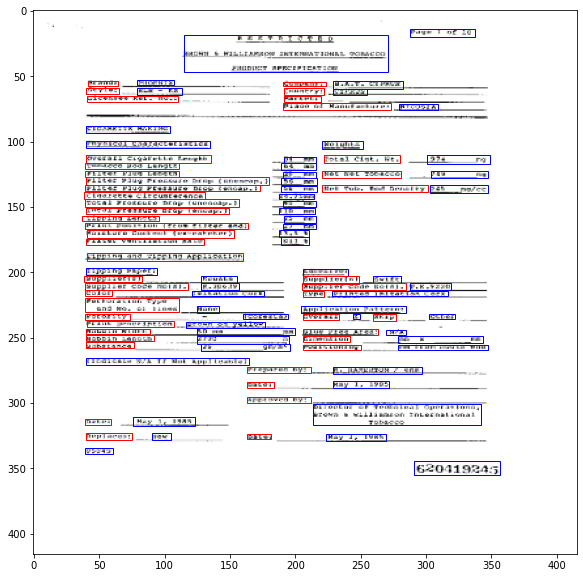

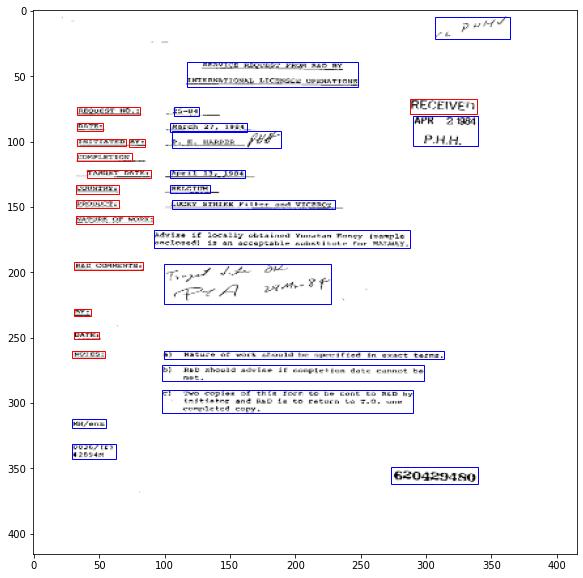

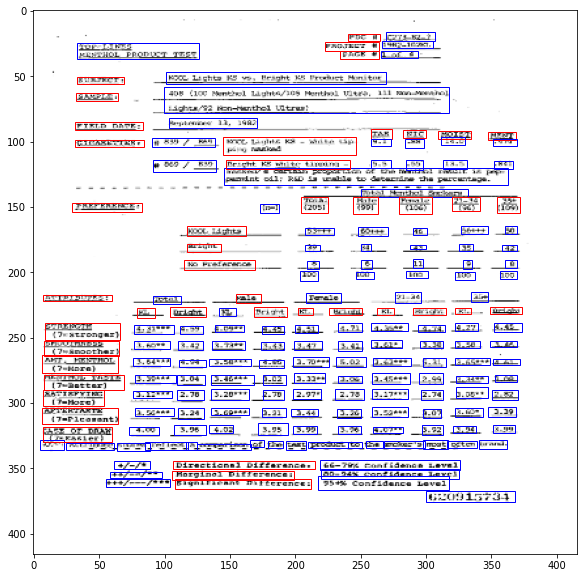

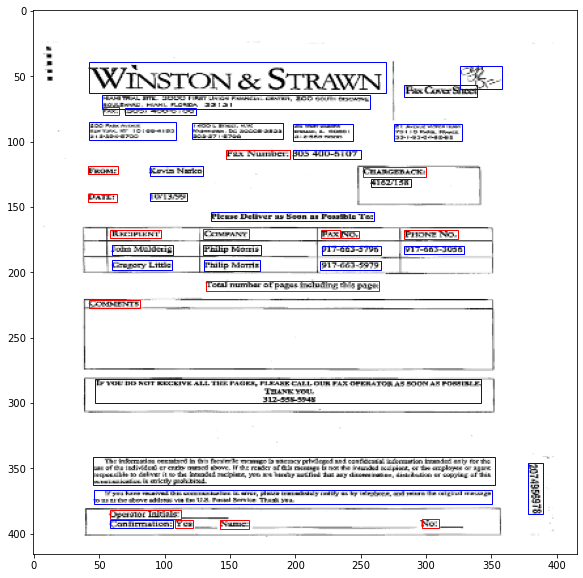

In [10]:
NUM_SAMPLES_TO_VISUALIZE = 5

for i in range(NUM_SAMPLES_TO_VISUALIZE):
  image, target = train_dataset[i]
  visualize_sample(image, target)

## Training the model

In [11]:
def create_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model

In [12]:
def train(train_data_loader, model, optimizer):
  model.train()
  
  for i, data in enumerate(train_data_loader):
    optimizer.zero_grad()
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()

    losses.backward()
    optimizer.step()

In [13]:
def validate(valid_data_loader, model):
  model.eval()

  metrics = []

  for i, data in enumerate(valid_data_loader):
    images, targets = data

    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    with torch.no_grad():
      preds = model(images)
      
    true_boxes = targets[0]["boxes"].cpu().numpy()
    pred_boxes = preds[0]["boxes"].cpu().numpy()

    true_labels = targets[0]["labels"].cpu().numpy()
    pred_labels = preds[0]["labels"].cpu().numpy()

    class_metrics = []

    # Calculating metrics (IoU, Precision, Recall, F1-Score)
    for label in [1, 2]:
      empty_array = np.zeros((RESIZE_TO, RESIZE_TO))

      true_mask = empty_array.copy()
      pred_mask = empty_array.copy()

      for i in range(len(true_boxes)):
        if true_labels[i] == label:
          box = true_boxes[i]

          true_mask = cv2.rectangle(
              true_mask,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              1,
              -1
          )

      for i in range(len(pred_boxes)):
        if pred_labels[i] == label:
          box = pred_boxes[i]

          pred_mask = cv2.rectangle(
              pred_mask,
              (int(box[0]), int(box[1])),
              (int(box[2]), int(box[3])),
              2, 
              -1
          )

      true_mask = np.matrix(true_mask)
      pred_mask = np.matrix(pred_mask)
      combined = np.asarray(true_mask + pred_mask).flatten()
      combined = np.squeeze(combined)

      unique, counts = np.unique(combined, return_counts=True)
      unique = [int(x) for x in unique]
      zipped = dict(zip(unique, counts))

      # True Negative, False Negative, False Positive, True Positive
      zipped["TN"] = 0
      zipped["FN"] = 0
      zipped["FP"] = 0
      zipped["TP"] = 0

      if 0 in zipped.keys():
        zipped["TN"] = zipped.pop(0)

      if 1 in zipped.keys():
        zipped["FN"] = zipped.pop(1)

      if 2 in zipped.keys():
        zipped["FP"] = zipped.pop(2)

      if 3 in zipped.keys():
        zipped["TP"] = zipped.pop(3)

      if zipped["TP"] == 0:
        class_metrics.append([0, 0, 0, 0])
      else:
        iou = zipped["TP"] / (zipped["FN"] + zipped["FP"] + zipped["TP"])
        precision = zipped["TP"] / (zipped["FP"] + zipped["TP"])
        recall = zipped["TP"] / (zipped["FN"] + zipped["TP"])
        f1_score = zipped["TP"] / (zipped["TP"] + 0.5 * (zipped["FP"] + zipped["FN"]))

        class_metrics.append([iou, precision, recall, f1_score])

    class_metrics = np.asarray(class_metrics)
    class_metrics = np.average(class_metrics, axis=0)
    metrics.append([class_metrics[0], class_metrics[1], class_metrics[2], class_metrics[3]])

  metrics = np.asarray(metrics)
  metrics = np.average(metrics, axis=0)

  metrics = {
      "IoU": metrics[0],
      "Precision": metrics[1],
      "Recall": metrics[2],
      "F1-Score": metrics[3]
  }

  return metrics

In [14]:
def print_metrics(metrics):
  for metric_name, value in metrics.items():
    print(f"{metric_name}: {value}")

In [15]:
model = create_model(NUM_CLASSES)
model = model.to(DEVICE)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

best_score = -1e9

all_metrics = []

for epoch in range(EPOCHS):
  print(f"\nEPOCH {epoch+1} of {EPOCHS}")

  start = time.time()
  train(train_loader, model, optimizer)
  metrics = validate(valid_loader, model)
  end = time.time()

  print(f"\nEpoch #{epoch+1}")
  print_metrics(metrics)
  print(f"Time elapsed {end - start:.3f} seconds for epoch {epoch}")

  if metrics["F1-Score"] > best_score:
    best_score = metrics["F1-Score"]
    print(f"\nBest validation F1-Score: {best_score}")
    print(f"Saving best model for epoch: {epoch+1}\n")
    torch.save({
        "model_state_dict": model.state_dict()
    }, BEST_MODEL_PATH)

  all_metrics.append([metrics["IoU"], metrics["Precision"], metrics["Recall"], metrics["F1-Score"]])

all_metrics = np.asarray(all_metrics)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]


EPOCH 1 of 50

Epoch #1
IoU: 0.19969457643007774
Precision: 0.23637637529492636
Recall: 0.6507249915979253
F1-Score: 0.31227840254848993
Time elapsed 94.133 seconds for epoch 0

Best validation F1-Score: 0.31227840254848993
Saving best model for epoch: 1


EPOCH 2 of 50

Epoch #2
IoU: 0.2704354361078531
Precision: 0.3922470250433133
Recall: 0.5490078824179238
F1-Score: 0.4153605938678407
Time elapsed 30.897 seconds for epoch 1

Best validation F1-Score: 0.4153605938678407
Saving best model for epoch: 2


EPOCH 3 of 50

Epoch #3
IoU: 0.28595763396725266
Precision: 0.4127541745171424
Recall: 0.5417794296481249
F1-Score: 0.43338383507634737
Time elapsed 30.225 seconds for epoch 2

Best validation F1-Score: 0.43338383507634737
Saving best model for epoch: 3


EPOCH 4 of 50

Epoch #4
IoU: 0.2979623767622241
Precision: 0.41630124224057524
Recall: 0.565114925648198
F1-Score: 0.44677267153474437
Time elapsed 30.113 seconds for epoch 3

Best validation F1-Score: 0.44677267153474437
Saving best

## Evaluating the model

In [16]:
def visualize_metrics(metrics):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.plot(metrics[:, 0], linewidth=3, label="IoU")
  ax.plot(metrics[:, 1], linewidth=3, label="Precision")
  ax.plot(metrics[:, 2], linewidth=3, label="Recall")
  ax.plot(metrics[:, 3], linewidth=3, label="F1-Score")

  ax.set_xlabel("Epochs", fontsize=20)
  ax.set_ylabel("Metric Value", fontsize=20)

  ax.set_title("Metrics Visualization", fontsize=20)

  plt.legend()
  plt.grid()
  plt.show()

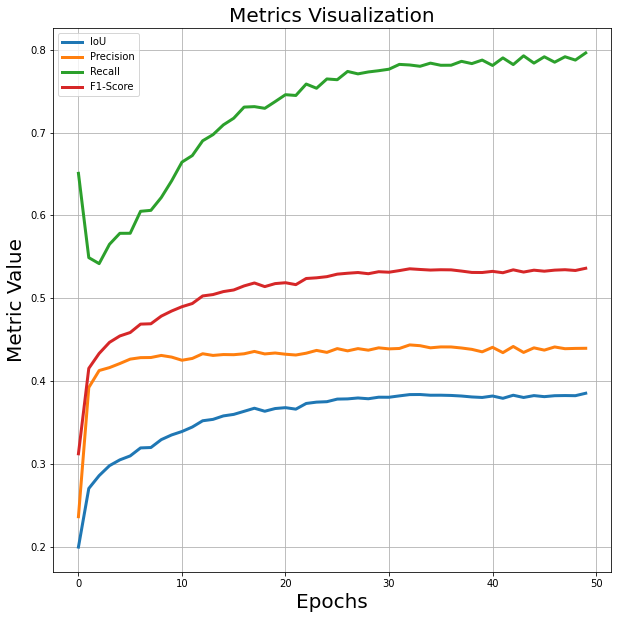

In [17]:
visualize_metrics(all_metrics)

In [18]:
def visualize_true_pred(image, true, pred):
  fig, ax = plt.subplots(1, 2, figsize=(20, 10))

  ax[0].imshow(image, cmap="gray")
  ax[1].imshow(image, cmap="gray")

  ax[0].set_title("True", fontsize=20)
  ax[1].set_title("Prediction", fontsize=20)

  for i, target in enumerate([true, pred]):
    if "boxes" in target.keys() and len(target["boxes"]) > 0:
      for box_num in range(len(target["boxes"])):
        box = target["boxes"][box_num]

        x = box[0]
        y = box[1]
        
        width = box[2] - box[0]
        height = box[3] - box[1]

        label = target["labels"][box_num]
        color = 'r' if label == 1 else 'b'

        rect = patches.Rectangle(
            (x, y), 
            width, 
            height, 
            linewidth=1, 
            edgecolor=color, 
            facecolor="None"
        )
        ax[i].add_patch(rect)
      
  plt.show()

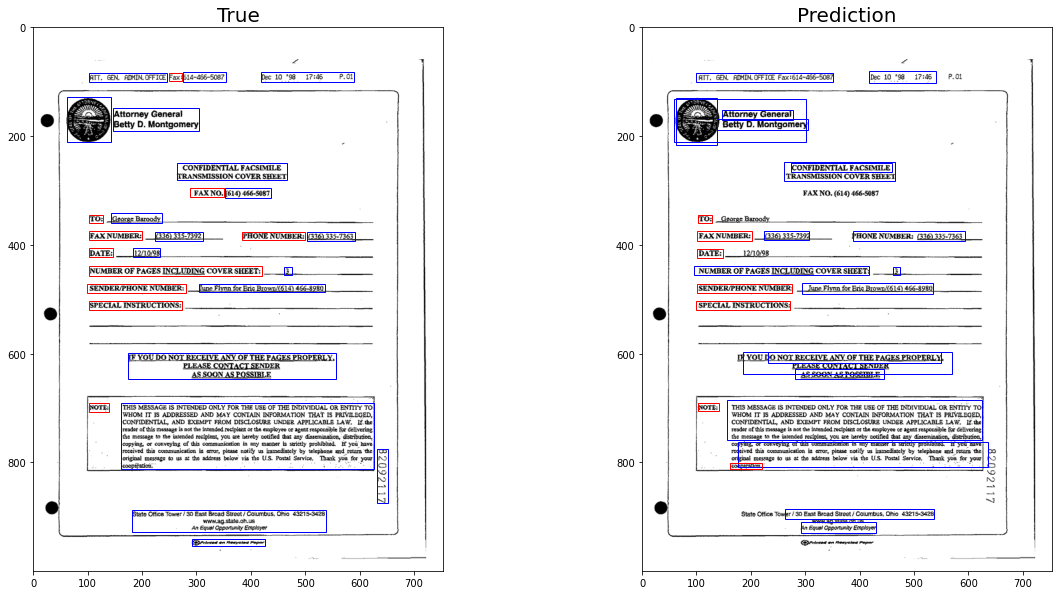

<ipython-input-18-48899817cee0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(20, 10))


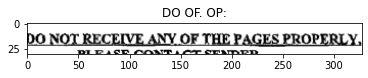

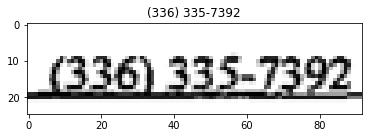

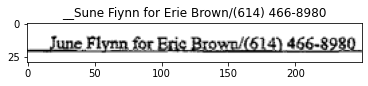

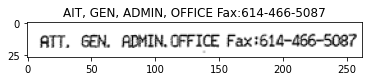

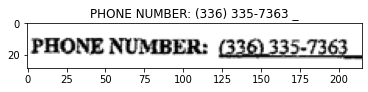

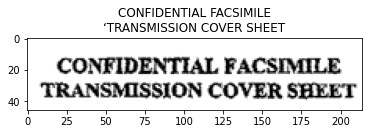

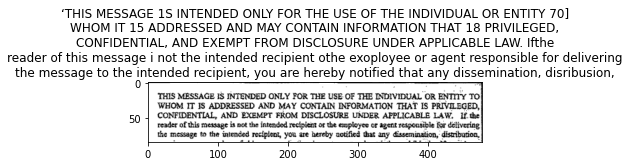

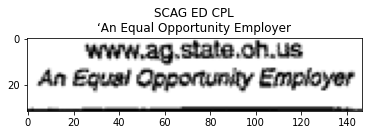

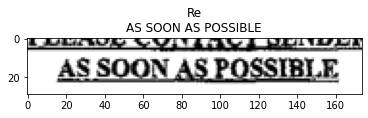

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


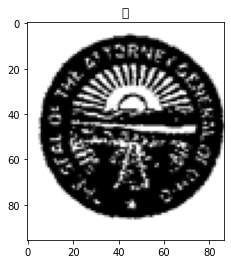

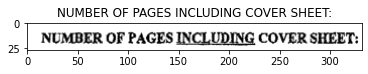

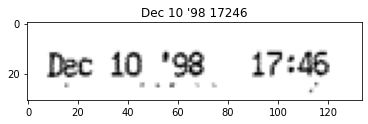

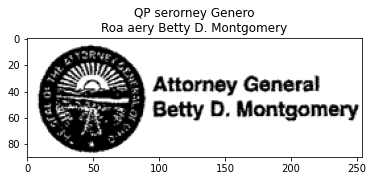

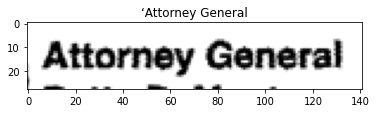

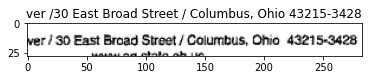

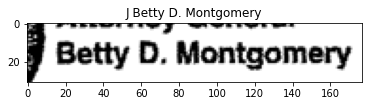

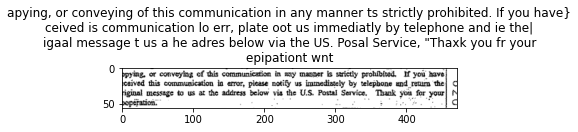

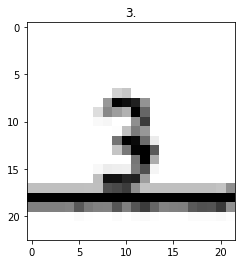

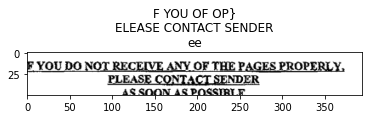

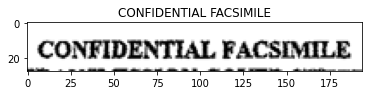

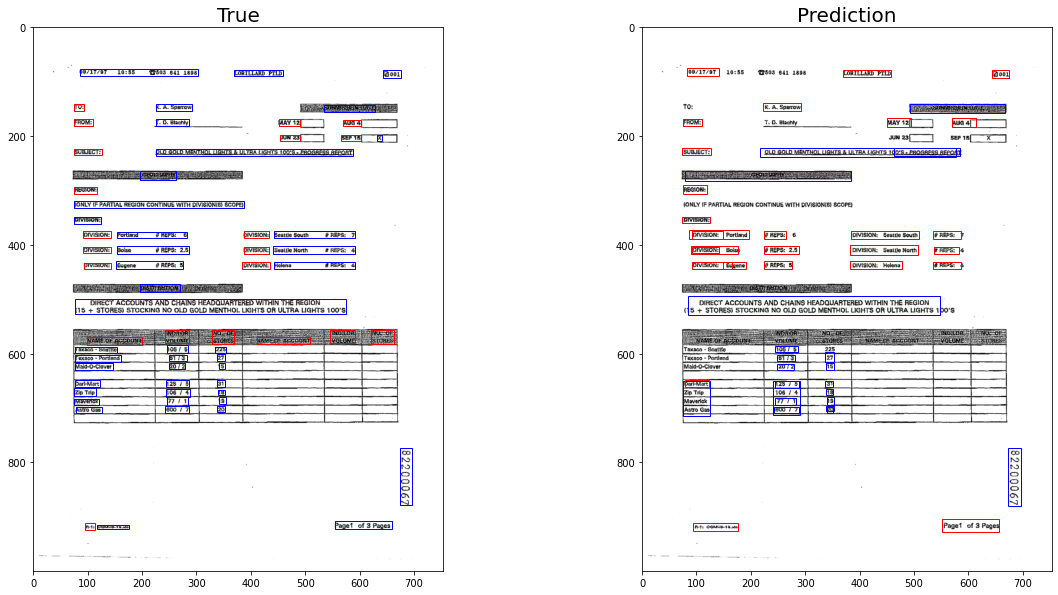

<ipython-input-19-55865a656d7c>:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-18-48899817cee0>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=(20, 10))


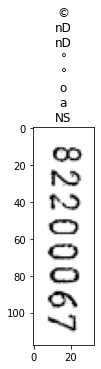

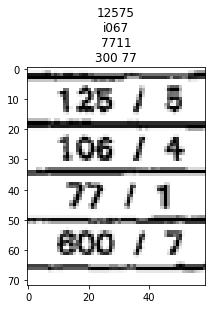

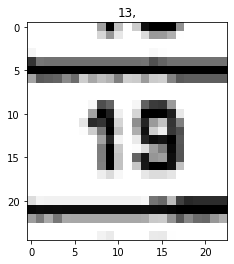

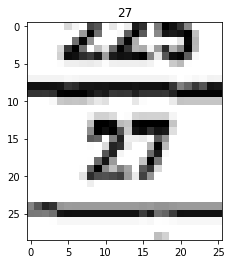

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


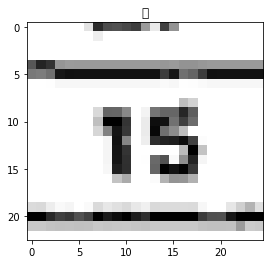

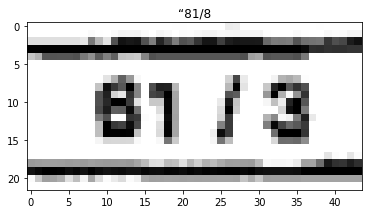

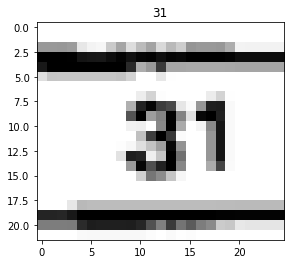

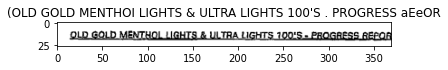

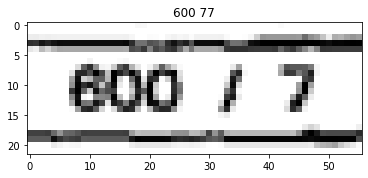

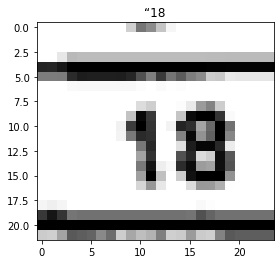

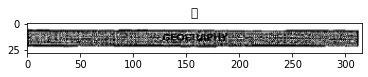

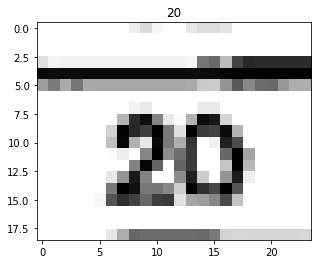

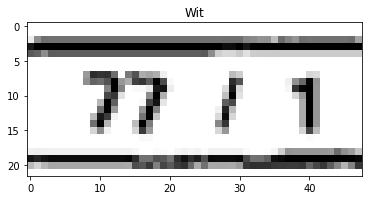

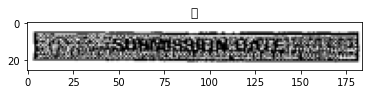

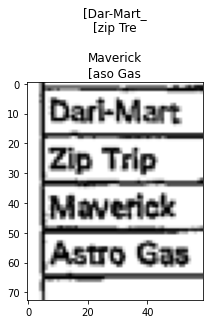

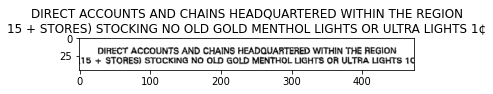

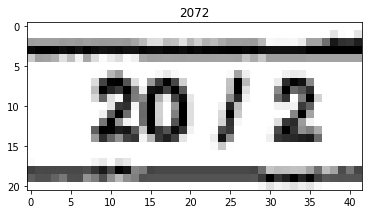

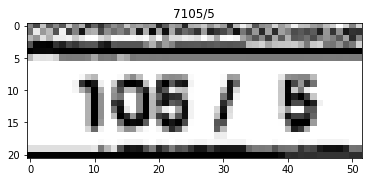

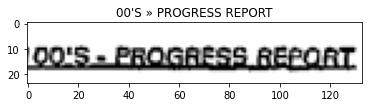

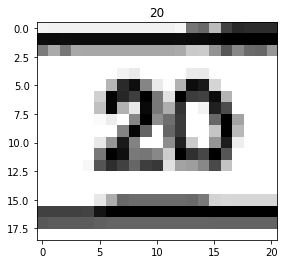

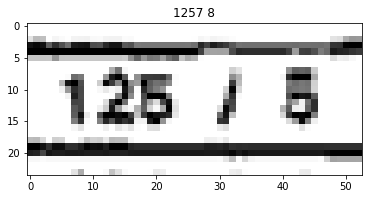

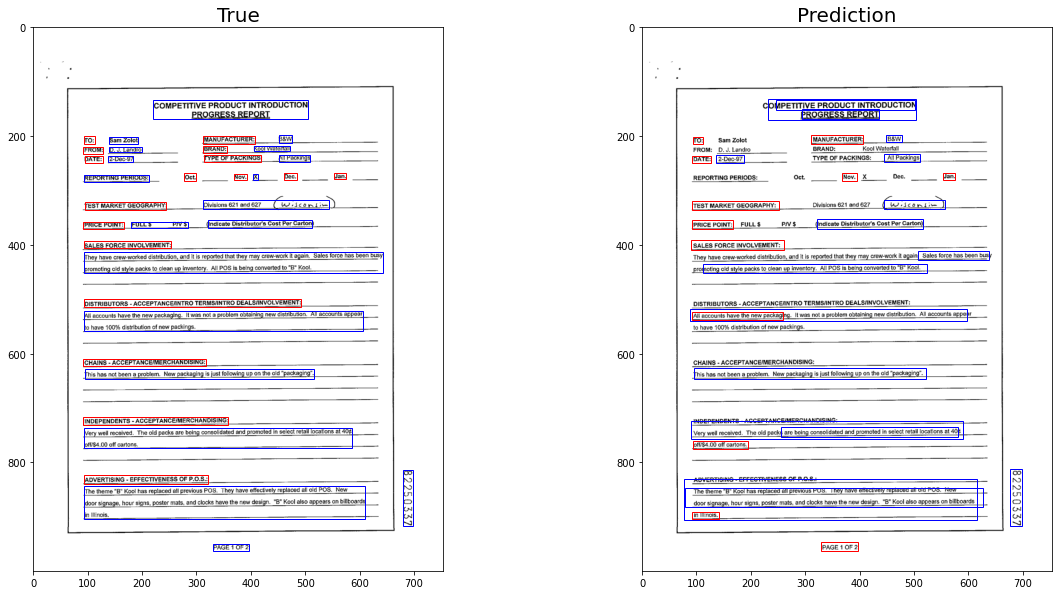

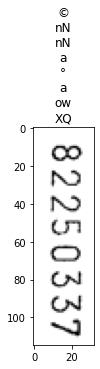

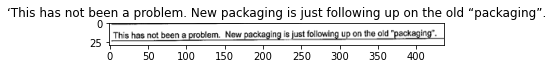

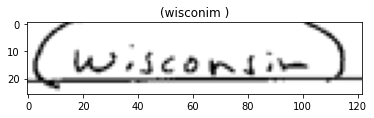

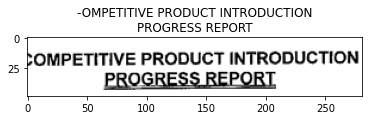

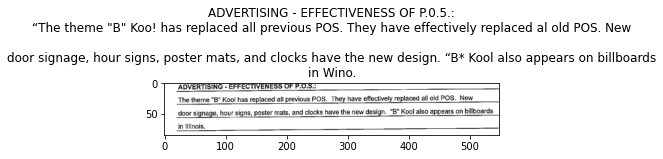

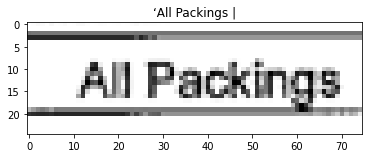

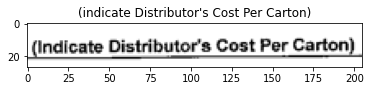

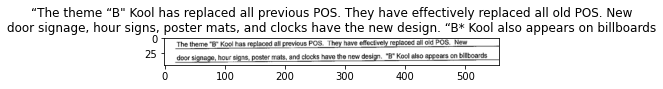

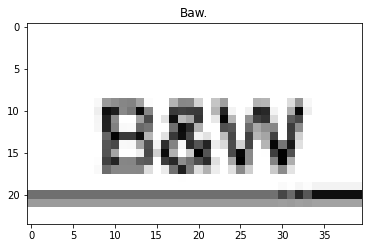

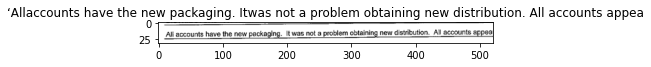

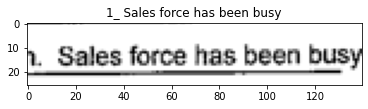

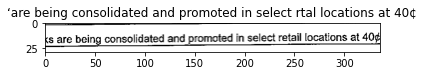

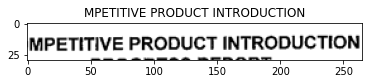

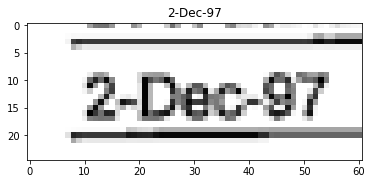

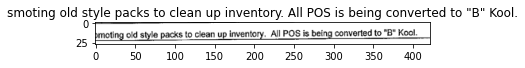

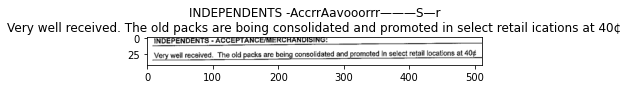

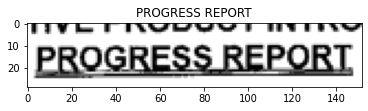

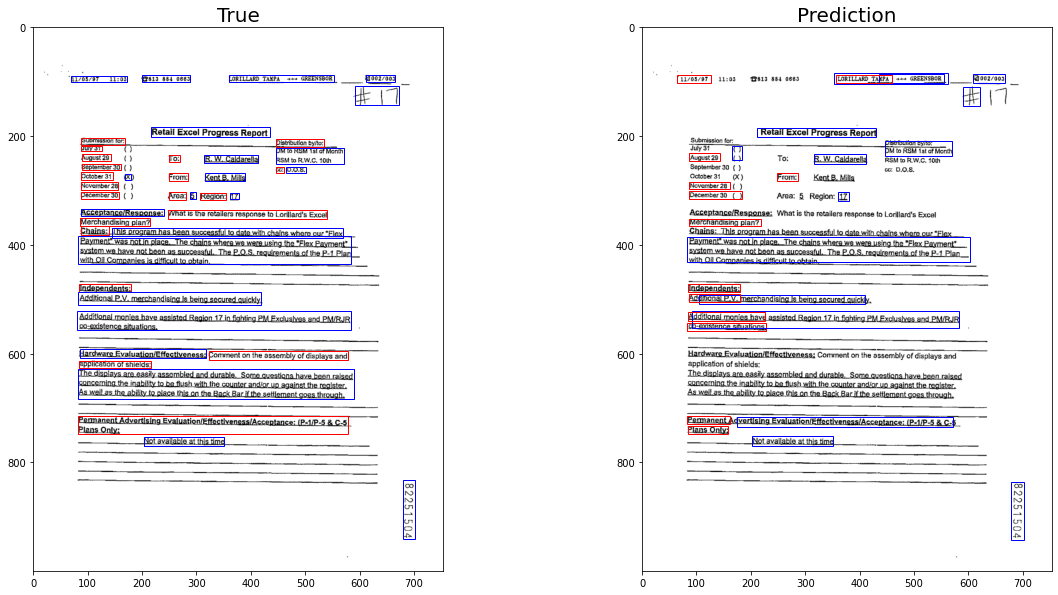

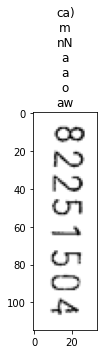

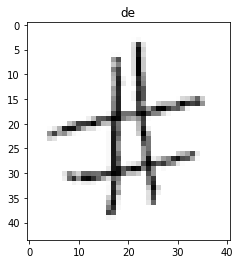

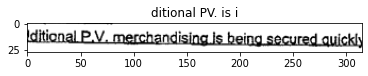

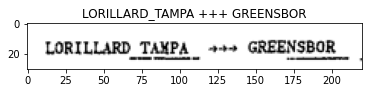

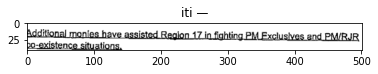

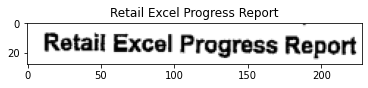

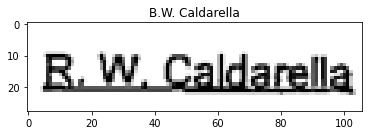

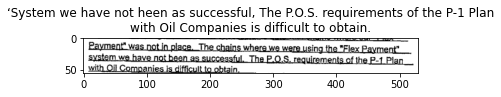

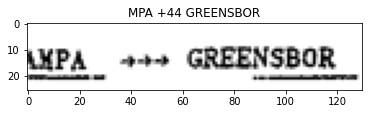

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


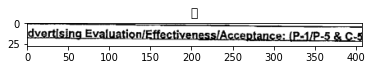

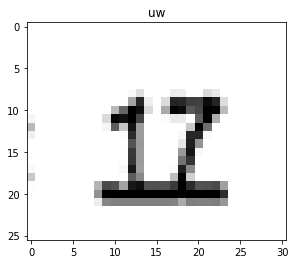

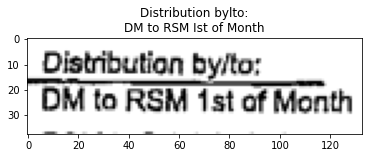

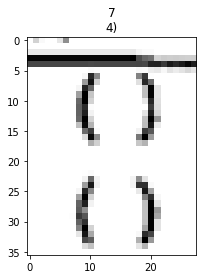

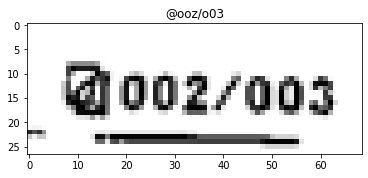

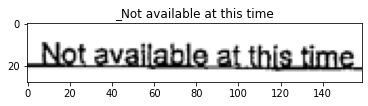

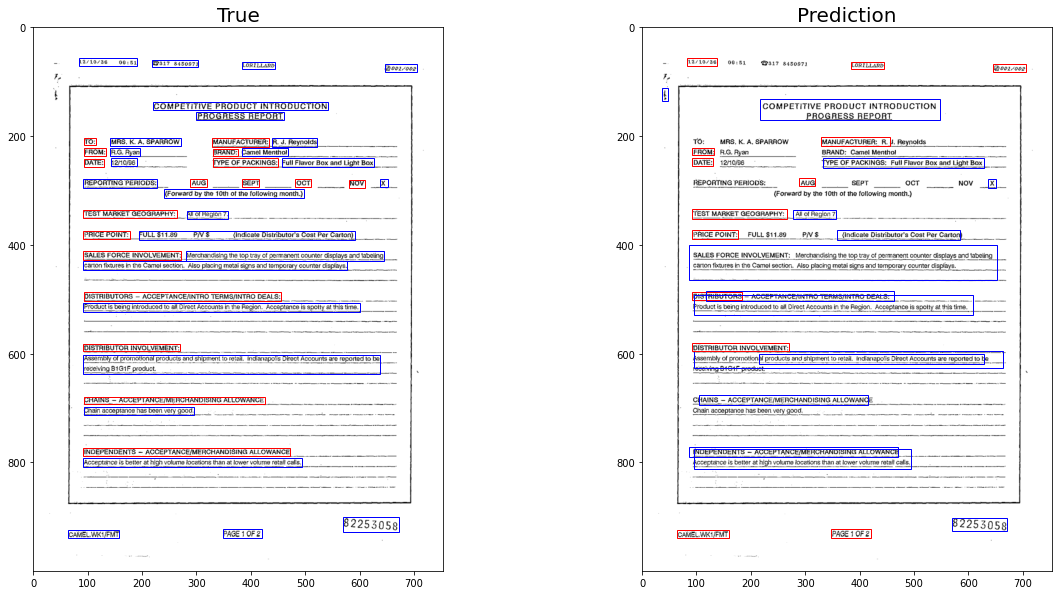

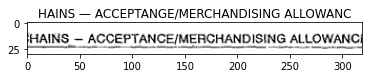

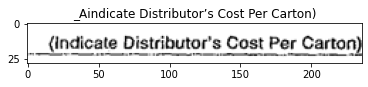

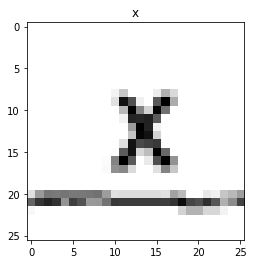

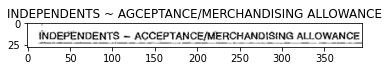

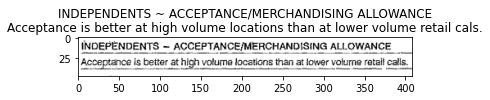

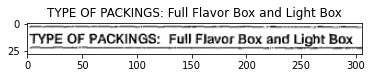

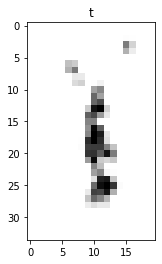

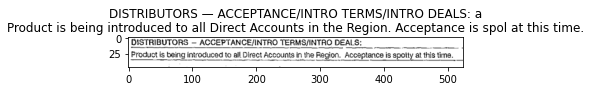

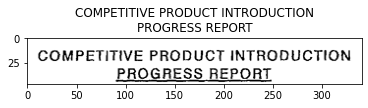

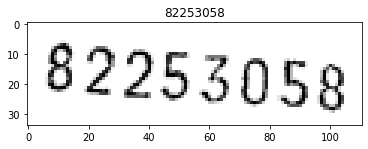

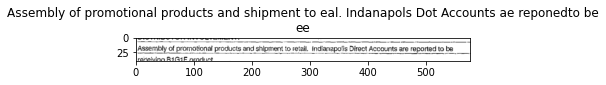

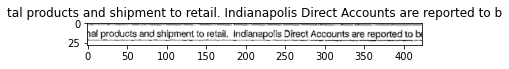

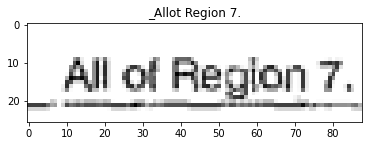

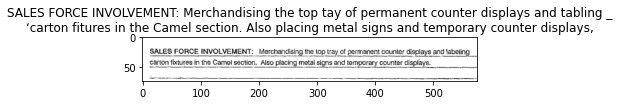

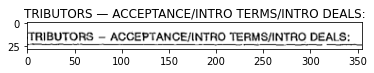

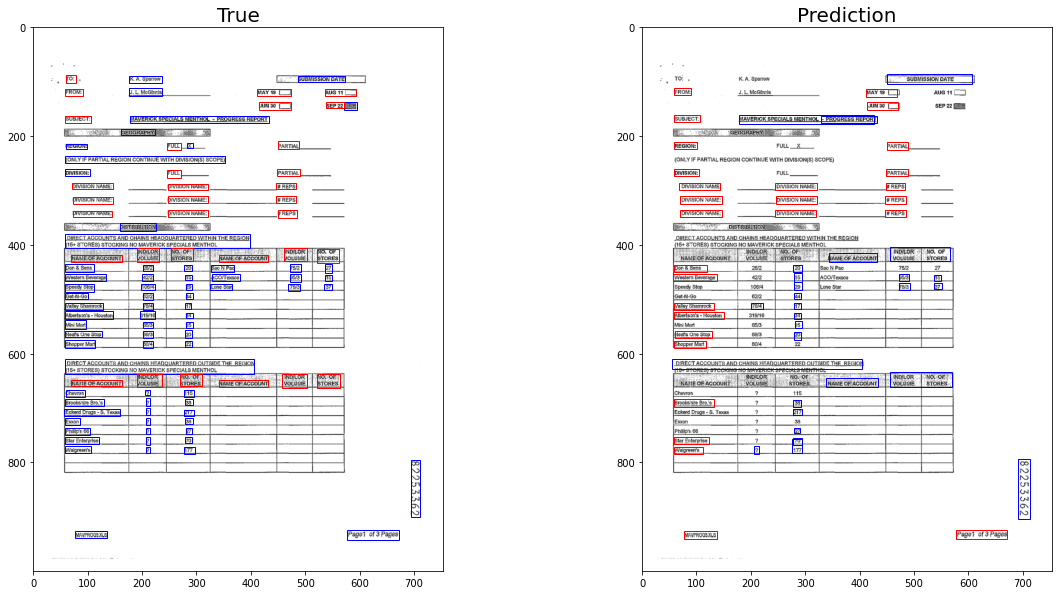

<ipython-input-19-55865a656d7c>:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-19-55865a656d7c>:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-19-55865a656d7c>:72: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-19-55865a656d7c>:72: Runt

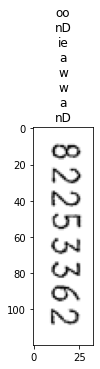

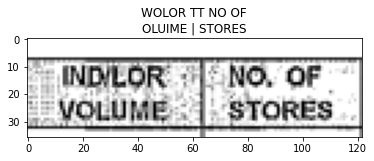

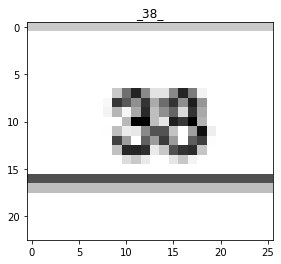

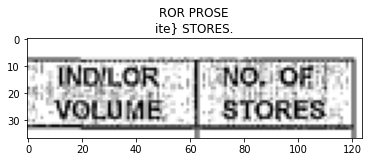

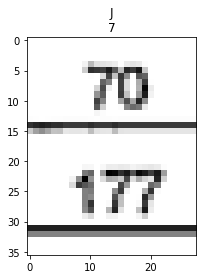

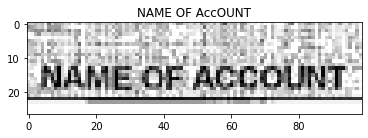

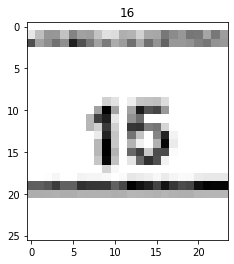

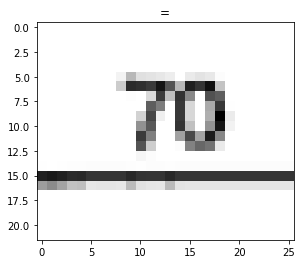

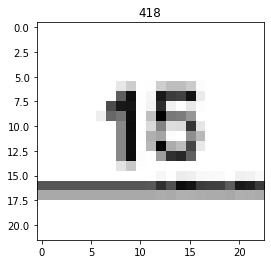

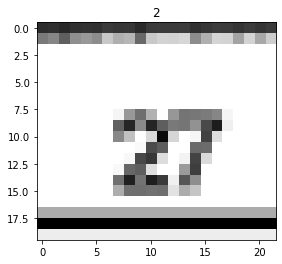

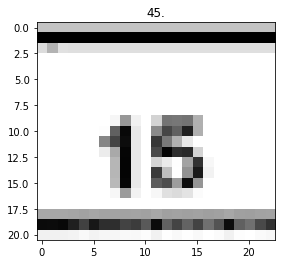

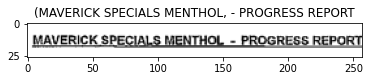

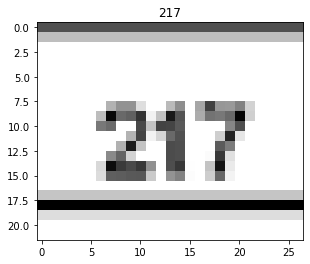

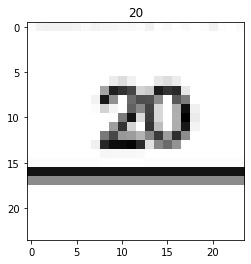

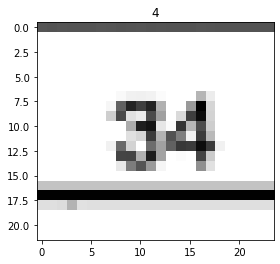

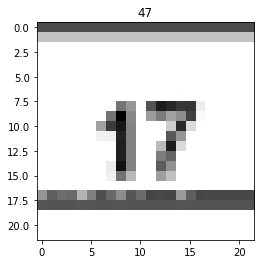

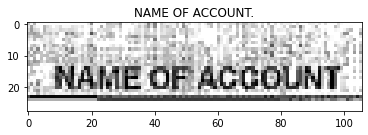

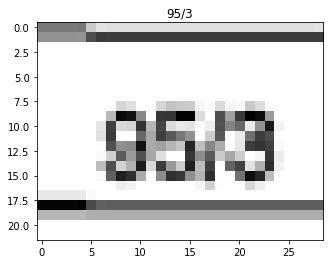

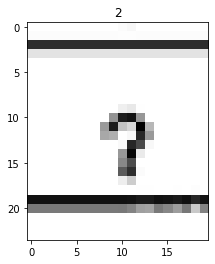

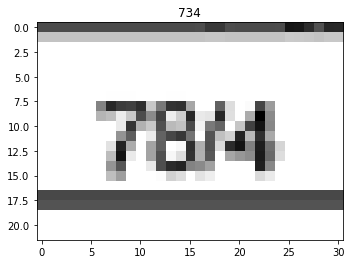

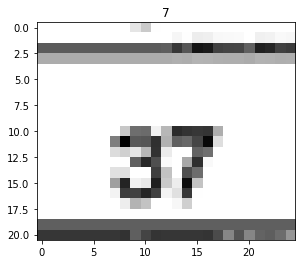

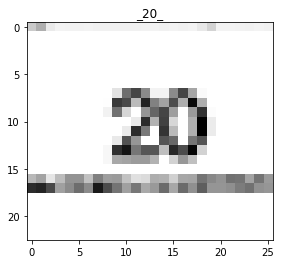

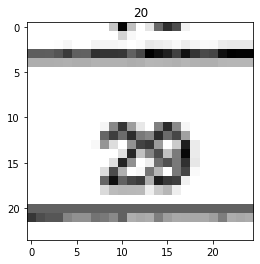

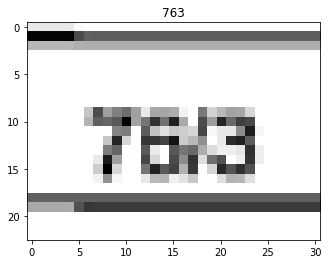

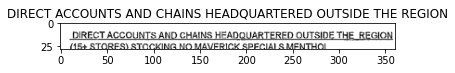

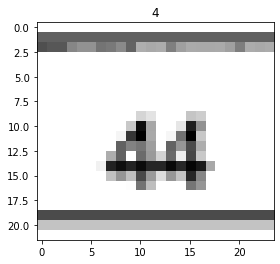

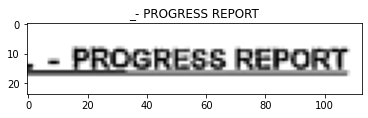

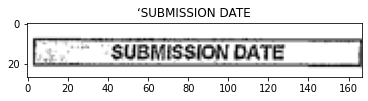

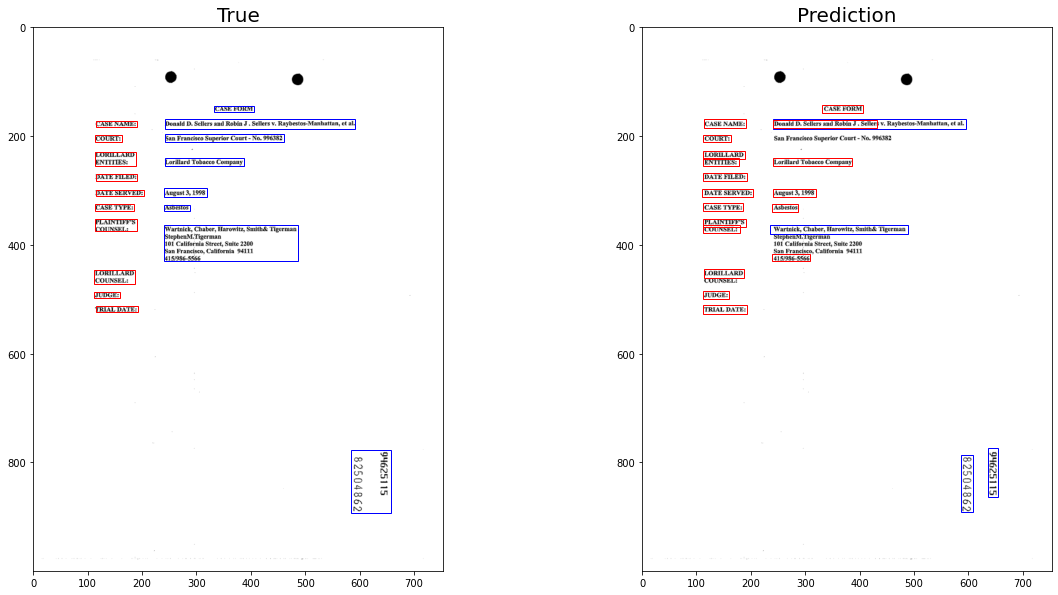

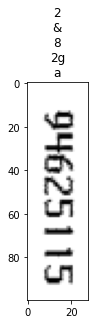

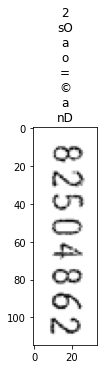

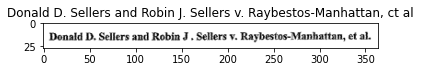

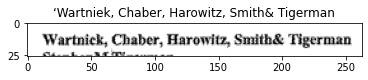

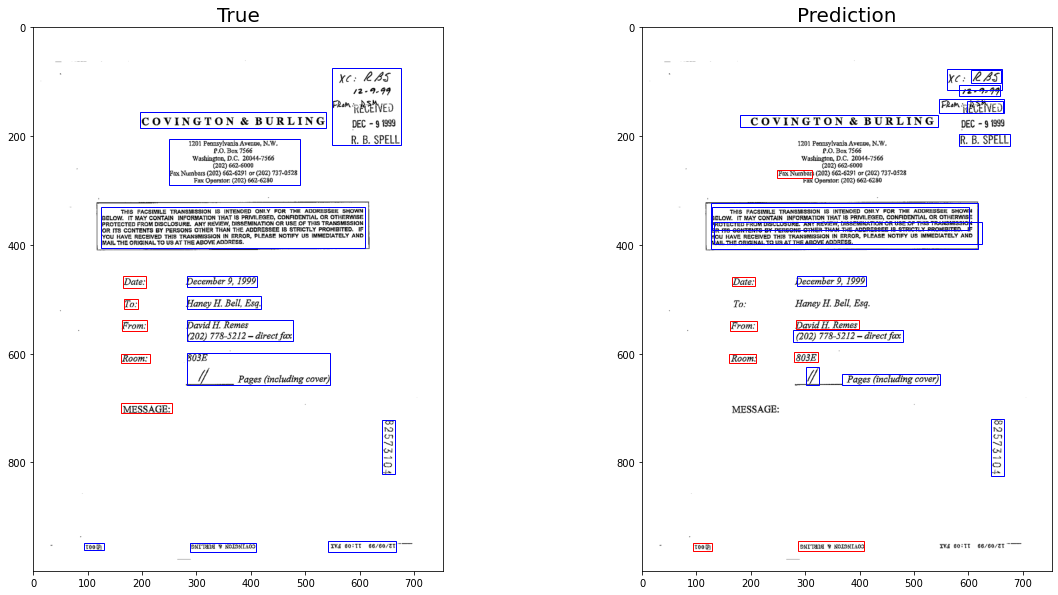

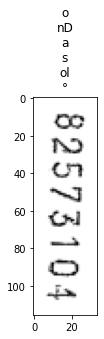

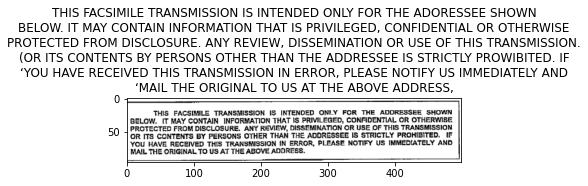

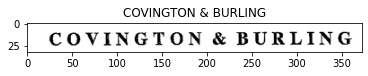

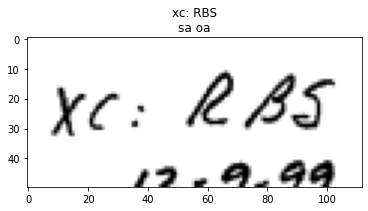

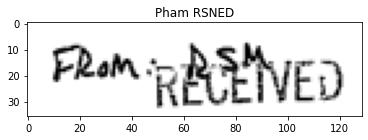

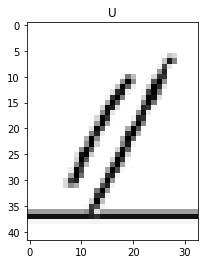

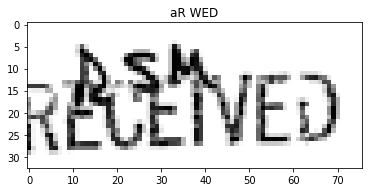

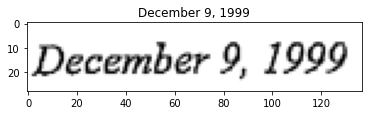

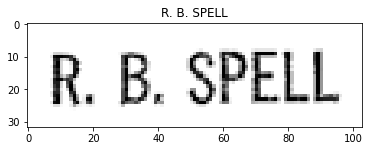

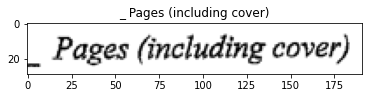

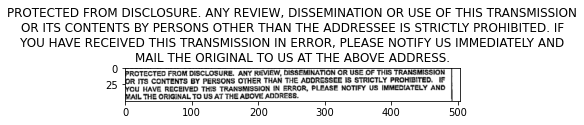

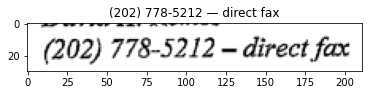

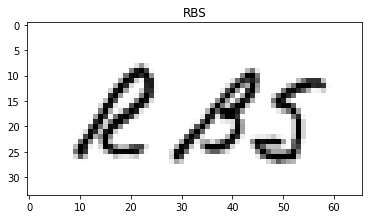

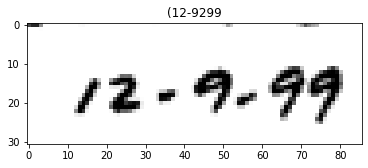

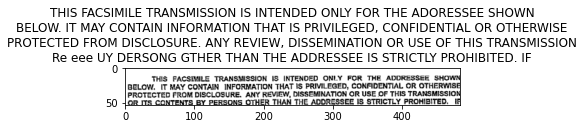

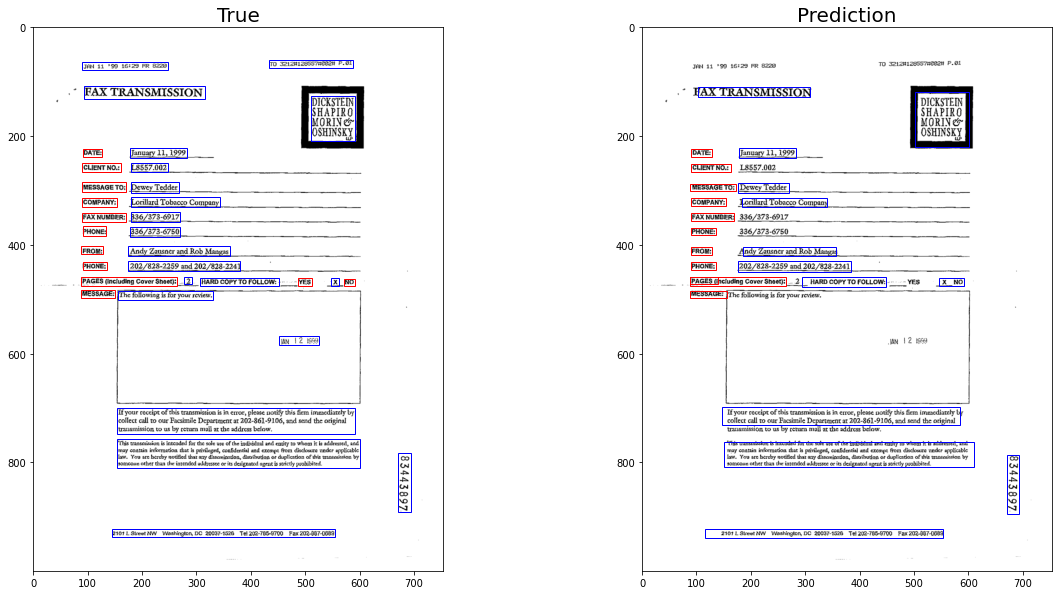

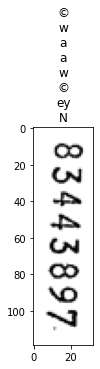

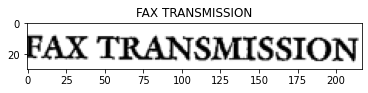

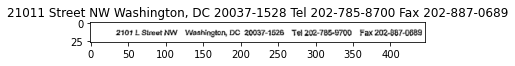

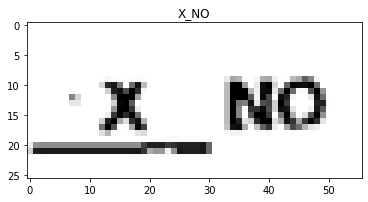

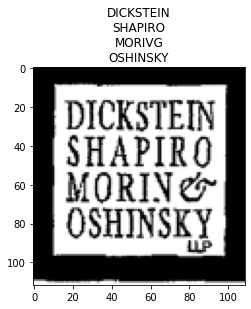

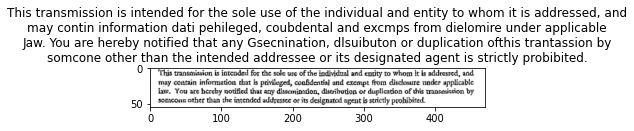

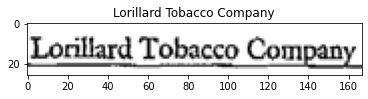

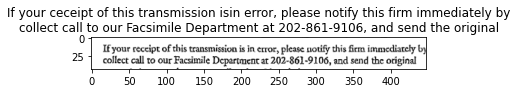

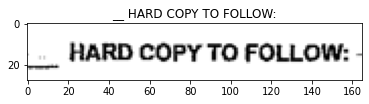

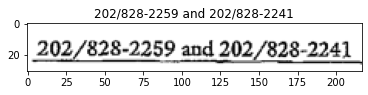

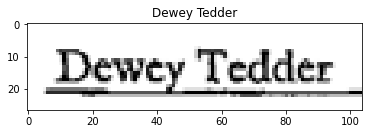

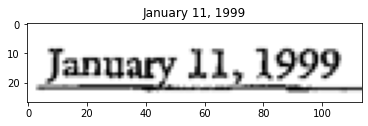

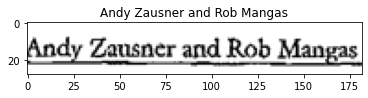

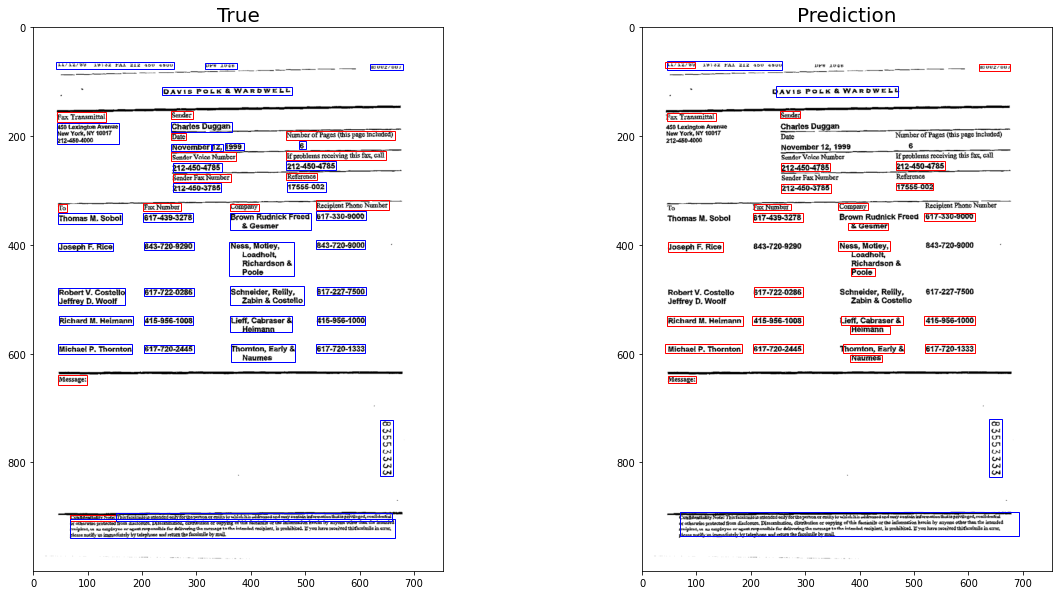

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12 missing from current font.
  font.set_text(s, 0, flags=flags)


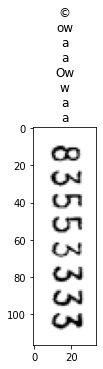

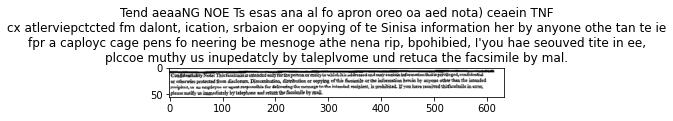

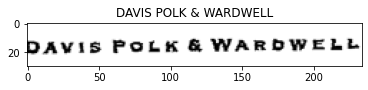

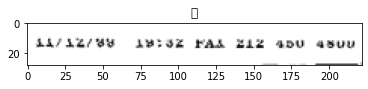

In [19]:
BUFFER = 10
CONFIDENCE_THRESHOLD = 0.6

model.load_state_dict(torch.load(BEST_MODEL_PATH)["model_state_dict"])
model.eval()

TESSERACT_CONFIG = r'--oem 3 --psm 6'

test_image_names = sorted(os.listdir(TEST_DATA_PATH / "images"))
test_label_names = sorted(os.listdir(TEST_DATA_PATH / "annotations"))

for i in range(len(test_image_names)):
  # Preparing image for inference
  image_name = test_image_names[i]
  image_path = TEST_DATA_PATH / "images" / image_name

  image = cv2.imread(str(image_path), 0)

  image_width = image.shape[1]
  image_height = image.shape[0]

  image_resized = cv2.resize(image, (RESIZE_TO, RESIZE_TO)).astype(np.float32)
  image_resized /= 255.0

  image_resized = transforms.ToTensor()(image_resized).unsqueeze(0)
  image_resized = image_resized.to(DEVICE)

  with torch.no_grad():
    pred = model(image_resized)

  # Preparing predictions for visualization
  pred_boxes = pred[0]["boxes"].cpu()

  pred_boxes[:, 0] = pred_boxes[:, 0] / RESIZE_TO * image_width
  pred_boxes[:, 1] = pred_boxes[:, 1] / RESIZE_TO * image_height
  pred_boxes[:, 2] = pred_boxes[:, 2] / RESIZE_TO * image_width
  pred_boxes[:, 3] = pred_boxes[:, 3] / RESIZE_TO * image_height
  
  pred_target = {}
  pred_target["scores"] = pred[0]["scores"].cpu()
  pred_target["boxes"] = pred_boxes[pred_target["scores"] > CONFIDENCE_THRESHOLD]
  pred_target["labels"] = pred[0]["labels"][pred_target["scores"] > CONFIDENCE_THRESHOLD].cpu()
  pred_target["scores"] = pred[0]["scores"][pred_target["scores"] > CONFIDENCE_THRESHOLD].cpu()

  # Preparing true labels for visualization
  label_name = test_label_names[i]
  label_path = TEST_DATA_PATH / "annotations" / label_name

  true_boxes, labels = read_box_coordinates(label_path)
  true_boxes = torch.as_tensor(true_boxes, dtype=torch.float32)

  true_target = {}
  true_target["boxes"] = true_boxes
  true_target["labels"] = labels

  visualize_true_pred(image, true_target, pred_target)

  # Applying OCR on predicted bounding boxes
  for i in range(len(pred_target["boxes"])):
    if pred_target["labels"][i] == 2:
      box = pred_target["boxes"][i]
      
      x1 = int(box[0])-5
      y1 = int(box[1])-5
      x2 = int(box[2])+5
      y2 = int(box[3])+5

      field_image = image[y1:y2, x1:x2]

      predicted_text = pytesseract.image_to_string(field_image, config=TESSERACT_CONFIG).replace("\n\x0c", '')

      plt.figure()
      plt.title(predicted_text)
      plt.imshow(field_image, cmap="gray")